In [336]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
from keybert import KeyBERT


# Preprocessing

In [337]:
df = pd.read_csv('https://raw.githubusercontent.com/arsyadCode/My_Thesis/main/Program/Data/Update/Scopus.csv')

In [338]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp(text)
    words = [token.text for token in doc if token.pos_ not in ['VERB', 'ADJ', "GPE"] and not token.is_digit and not token.is_currency and not token.is_space and not token.text.isnumeric() and len(token)>2]
    return ' '.join(words)

# Melakukan preprocessing pada kolom 'abstrak'
df['Abstrak'] = df['Abstract'].apply(preprocess_text)
data = df['Abstrak']
df['Abstract'] = df['Abstract'].apply(preprocess_text)

In [339]:
display(df['Abstrak'].head())
df['Abstract'].head()

0    the covid19 pandemic has the course the econom...
1    government has strongly announcement the publi...
2    carbon storage peat ecosystems over thousands ...
3    sector one the energyconsuming districts count...
4    interventions forests have deforestation and f...
Name: Abstrak, dtype: object

0    the covid19 pandemic has the course the econom...
1    government has strongly announcement the publi...
2    carbon storage peat ecosystems over thousands ...
3    sector one the energyconsuming districts count...
4    interventions forests have deforestation and f...
Name: Abstract, dtype: object

In [340]:
def extract_keywords(sentence):
    doc = nlp(sentence)
    keywords = [str(token.text.lower()) for token in doc if token.lemma_]
    return keywords

def extract_keywords2(sentence):
    doc = nlp(sentence)
    keywords2 = [str(token.text.lower()) for token in doc if not token.is_stop]
    return keywords2

keywords_array = []
keywords_array2 = []

# Similiar with Unigram
for _, row in df.iterrows():
    sentence2 = row['Abstrak']
    keywords2 = extract_keywords2(sentence2)
    keywords_array2.extend(keywords2)

for _, row in df.iterrows():
    sentence = row['Abstract']
    keywords = extract_keywords(sentence)
    keywords_array.extend(keywords)

keywords_list2 = pd.DataFrame(list(set(keywords_array2)))
keywords_list = pd.DataFrame(list(set(keywords_array)))
abstract_count2 = Counter(keywords_array2)
abstract_count = Counter(keywords_array)

result_dict = {key: abstract_count[key] for key in keywords_array if key in abstract_count}
sorted_result = dict(sorted(result_dict.items(), key=lambda item: (item[1], item[0])))
result_dict2 = {key: abstract_count2[key] for key in keywords_array2 if key in abstract_count2}
sorted_result2 = dict(sorted(result_dict2.items(), key=lambda item: (item[1], item[0])))

In [341]:
display(abstract_count)
abstract_count2

Counter({'the': 5030,
         'and': 2808,
         'for': 750,
         'emissions': 678,
         'that': 677,
         'this': 629,
         'from': 608,
         'indonesia': 460,
         'with': 451,
         'energy': 417,
         'are': 407,
         'was': 395,
         'greenhouse': 382,
         'gas': 371,
         'study': 339,
         'ghg': 314,
         'carbon': 302,
         'emission': 300,
         'has': 291,
         'oil': 283,
         'were': 282,
         'palm': 251,
         'co2': 238,
         'which': 232,
         'production': 231,
         'climate': 229,
         'change': 207,
         'can': 191,
         'forest': 188,
         'results': 183,
         'land': 177,
         'research': 169,
         'have': 161,
         'also': 160,
         'development': 157,
         'impact': 156,
         'under': 154,
         'data': 152,
         'one': 152,
         'these': 150,
         'use': 149,
         'its': 146,
         'all': 141,
         '

Counter({'emissions': 678,
         'indonesia': 460,
         'energy': 417,
         'greenhouse': 382,
         'gas': 371,
         'study': 339,
         'ghg': 314,
         'carbon': 302,
         'emission': 300,
         'oil': 283,
         'palm': 251,
         'co2': 238,
         'production': 231,
         'climate': 229,
         'change': 207,
         'forest': 188,
         'results': 183,
         'land': 177,
         'research': 169,
         'development': 157,
         'impact': 156,
         'data': 152,
         'use': 149,
         'soil': 137,
         'power': 129,
         'countries': 126,
         'ch4': 125,
         'rice': 125,
         'water': 122,
         'peat': 121,
         'system': 120,
         'area': 113,
         'management': 110,
         'analysis': 106,
         'ltd': 106,
         'impacts': 106,
         'factors': 103,
         'consumption': 102,
         'industry': 102,
         'method': 101,
         'gases': 96,
         'mod

In [342]:
# Jumlah data untuk Teori Luhn dan Clustering
print(len(keywords_list), len(keywords_list2))

4754 4580


In [343]:
df = pd.read_csv('https://raw.githubusercontent.com/arsyadCode/My_Thesis/main/Program/Data/Update/Scopus.csv')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp(text)
    words = [token.text for token in doc if token.pos_ not in ['VERB', 'ADJ', "GPE"] and not token.is_digit and not token.is_currency and not token.is_space and not token.text.isnumeric() and len(token)>2 and not token.is_stop]
    return ' '.join(words)

# Melakukan preprocessing pada kolom 'abstrak'
df['Abstrak'] = df['Abstract'].apply(preprocess_text)
data = df['Abstrak']

# K-Means Clustering

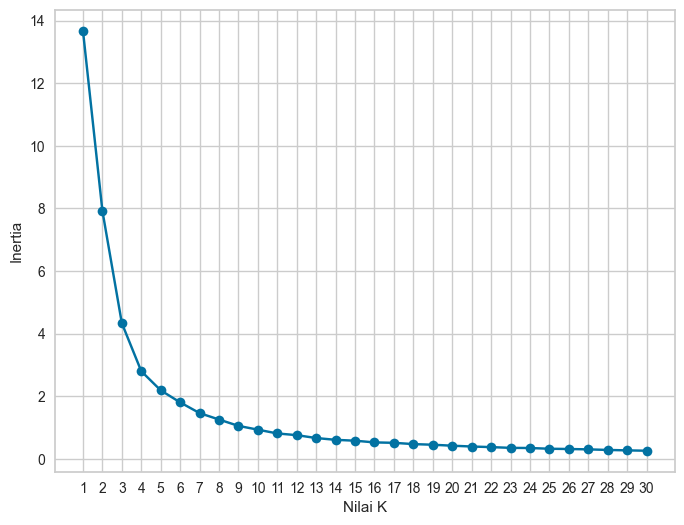

In [344]:
vectorizer = TfidfVectorizer(max_features=len(keywords_list2))  # You can adjust the max_features parameter
X = vectorizer.fit_transform(df['Abstrak'])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

num_clusters_range = range(1, 31)
inertia_values = []

for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(num_clusters_range, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel('Nilai K')
plt.ylabel('Inertia')
# plt.title('Elbow Plot untuk menentukan Cluster K-Means')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

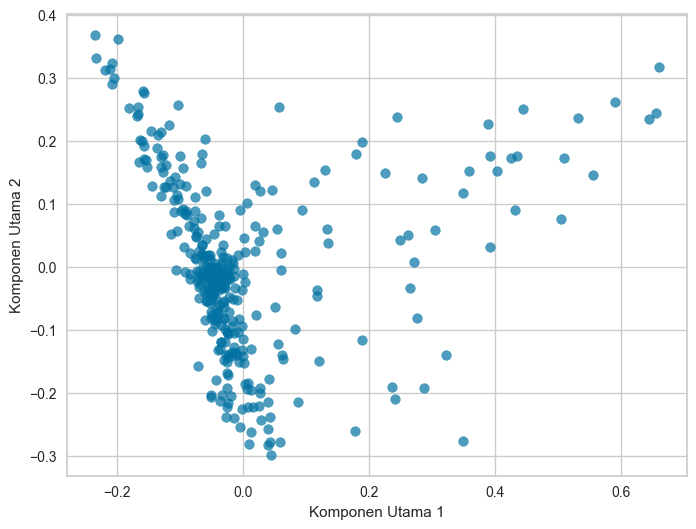

In [345]:
# Visualisasi PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
# plt.title('Visualisasi klaster hasil dari PCA')
plt.grid(True)
plt.show()

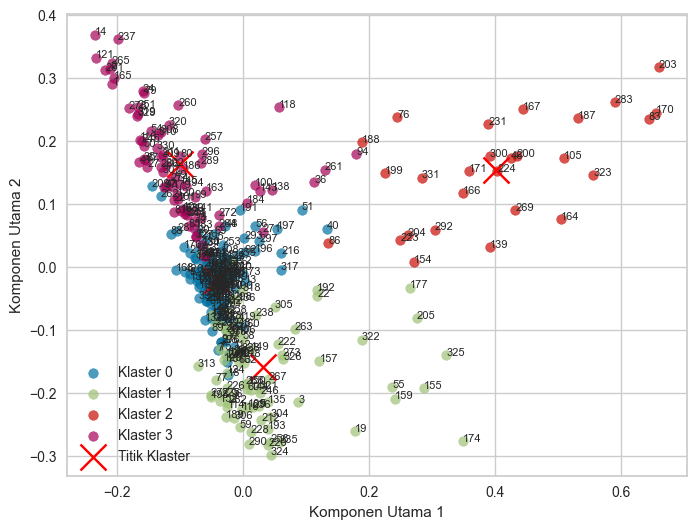

In [346]:
num_clusters = 4  # Setelah didapatkan pada proses sebelumnya
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

cluster_labels = kmeans.labels_
cluster_centers = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = X_pca[cluster_labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Klaster {i}', alpha=0.7)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=350, c='red', label='Titik Klaster')

for i, abstract in enumerate(df['Abstrak']):
    plt.text(X_pca[i, 0], X_pca[i, 1], f"{i+1}", fontsize=8)

plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
# plt.title('Klasterisasi Pewarnaan dengan K-Means')
plt.legend()
plt.grid(True)
plt.show()

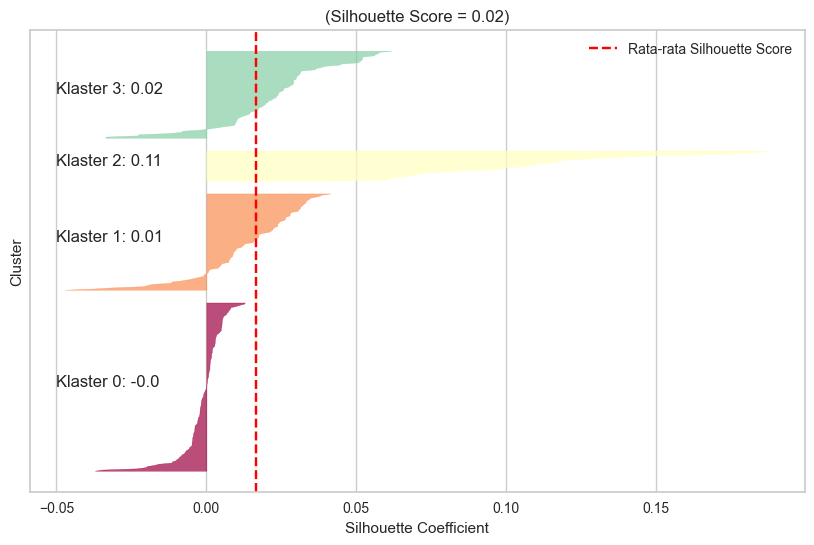

In [347]:
#Visualisasi Silhouette Clusters Plot

silhouette_avg = silhouette_score(X.toarray(), cluster_labels)
silhouette_values = silhouette_samples(X.toarray(), cluster_labels)

plt.figure(figsize=(10, 6))
y_lower = 10

for i in range(num_clusters):
    ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.Spectral(float(i) / num_clusters)
    
    plt.fill_betweenx(np.arange(y_lower, y_upper), ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Klaster {i}: {round(np.mean(ith_cluster_silhouette_values), 2)}")
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--", label="Rata-rata Silhouette Score")

plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
# plt.title("Silhouette Plot untuk K-Means Clustering (Silhouette Score = " + str(round(silhouette_avg, 2)) + ")")
plt.title("(Silhouette Score = " + str(round(silhouette_avg, 2)) + ")")
plt.legend()
plt.yticks([])
plt.show()

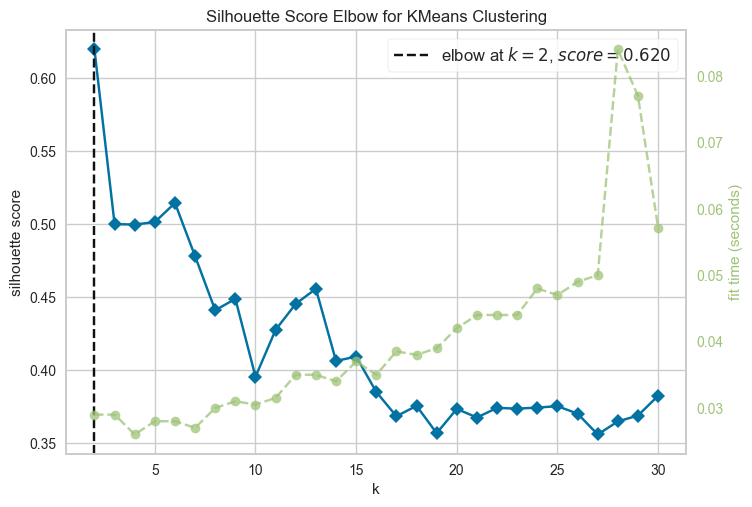

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [348]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 21),metric='silhouette', timings= True)
visualizer.fit(X_pca)
visualizer.show()   

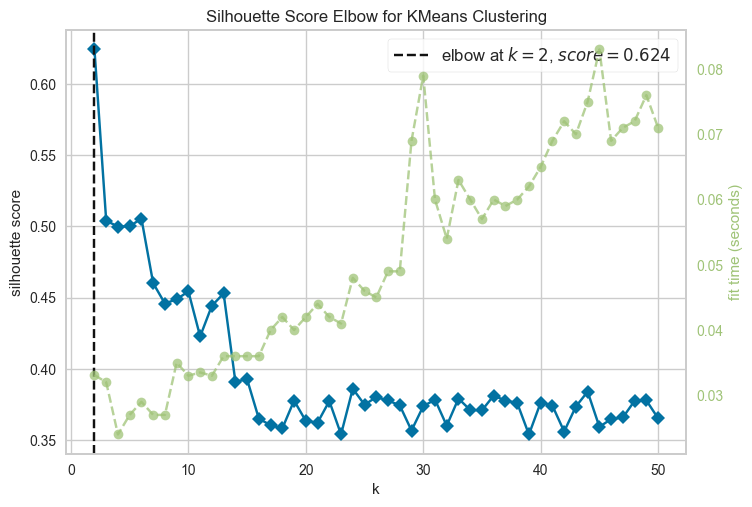

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [366]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 51),metric='silhouette', timings= True)
visualizer.fit(X_pca)
visualizer.show()   

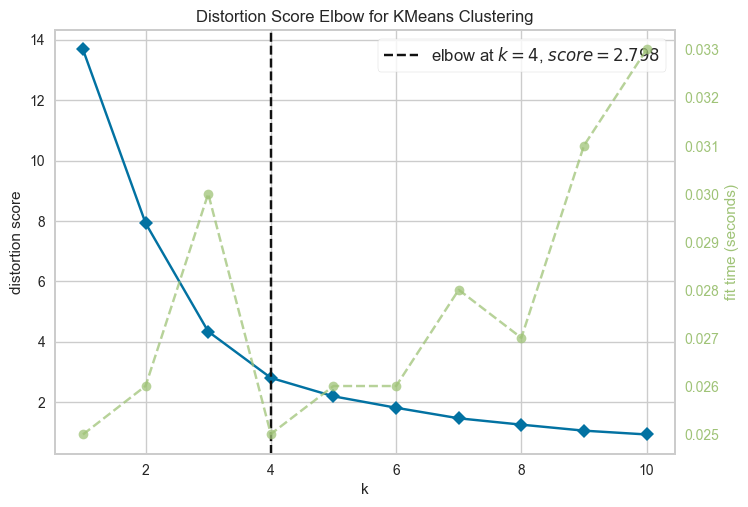

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [349]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11))
visualizer.fit(X_pca)
visualizer.show()

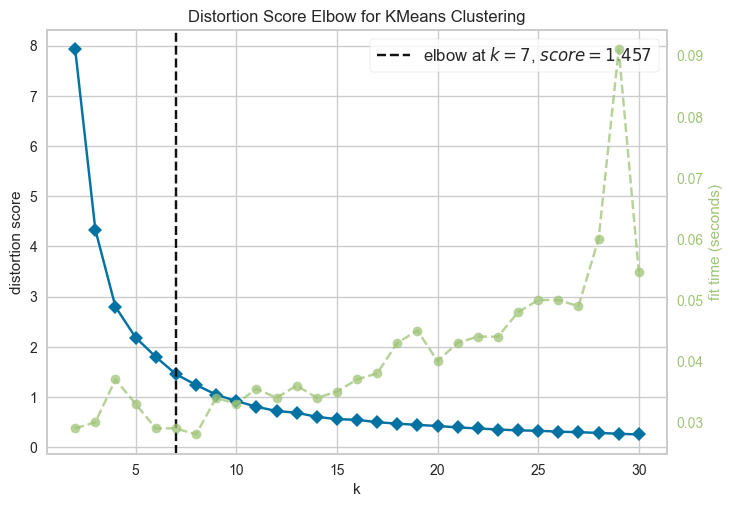

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [350]:
# Elbow Method for K means

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,31), timings= True, title=None)
visualizer.fit(X_pca)        # Fit data to visualizer
visualizer.show()  

#Title: Distortion Score Elbow for KMeans Clustering

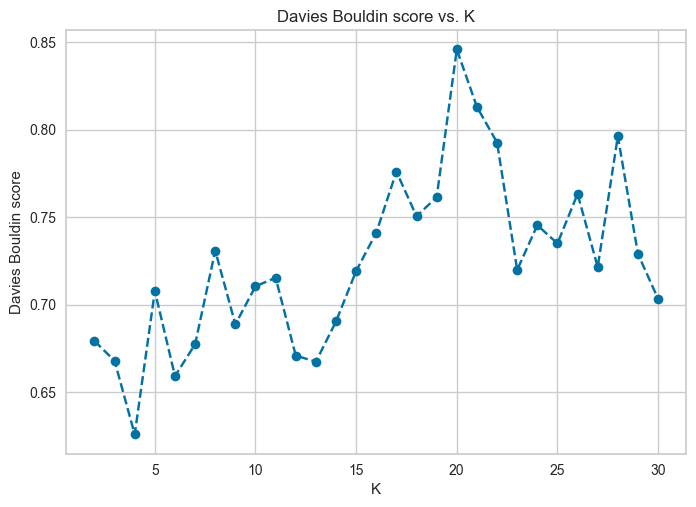

In [351]:
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score

def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit_predict(data)
    score = davies_bouldin_score(data, model)
    return score

# Perform PCA on the data before clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)

scores = []
centers = list(range(2, 31))
for center in centers:
    scores.append(get_kmeans_score(X_pca, center))

plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.title('Davies Bouldin score vs. K')
plt.show()

In [352]:
data

0      covid19 pandemic course economy world indonesi...
1      government strongly announcement public line p...
2      carbon storage peat ecosystems thousands years...
3      sector energyconsuming districts countries emi...
4      interventions forests deforestation forest deg...
                             ...                        
328    need energy especially energy indonesia object...
329    paper impact energy production tariff schemes ...
330    oil gas industry contribution greenhouse gas r...
331    increase greenhouse gasses effect causes clima...
332    dynamics carbon mineralization peats areas sig...
Name: Abstrak, Length: 333, dtype: object

In [353]:
# Hasil kata kunci berdasarkan hasil K-Means Clustering
vectorizer = TfidfVectorizer(max_features=len(keywords_list2))  
X = vectorizer.fit_transform(data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_pca)

keywords_per_cluster = {}
for i in range(num_clusters):
    cluster_data = [data[j] for j in range(len(data)) if cluster_labels[j] == i]
    cluster_text = ' '.join(cluster_data)
    cluster_vectorizer = TfidfVectorizer()
    cluster_X = cluster_vectorizer.fit_transform([cluster_text])
    feature_names = cluster_vectorizer.get_feature_names_out()
    tfidf_scores = cluster_X.toarray()[0]
    sorted_indices = np.argsort(tfidf_scores)[::-1]

    N = 20  #Total kata kunci yang diinginkan setiap cluster
    keywords = [feature_names[idx] for idx in sorted_indices[:N]]
    keywords_per_cluster[i] = keywords

for i in range(num_clusters):
    print(f"Cluster {i} Keywords: {', '.join(keywords_per_cluster[i])}")

Cluster 0 Keywords: emissions, indonesia, greenhouse, carbon, ghg, study, emission, gas, climate, change, co2, results, development, research, countries, data, production, impact, food, impacts
Cluster 1 Keywords: emissions, forest, soil, peat, rice, ch4, indonesia, greenhouse, land, gas, study, carbon, water, ghg, n2o, emission, area, peatlands, management, palm
Cluster 2 Keywords: oil, palm, indonesia, production, biodiesel, emissions, industry, gas, land, greenhouse, study, products, impact, supply, ghg, change, impacts, ispo, cpo, rspo
Cluster 3 Keywords: energy, power, indonesia, gas, emissions, electricity, production, greenhouse, co2, study, generation, emission, plant, consumption, ghg, coal, system, use, biogas, efficiency


In [354]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Step 4: Create a dictionary to store texts for each cluster
cluster_texts = {}
for i, abstract_text in enumerate(data):
    cluster_label = cluster_labels[i]
    if cluster_label not in cluster_texts:
        cluster_texts[cluster_label] = []
    cluster_texts[cluster_label].append(abstract_text)

# # Step 5: Print texts for each cluster
# for cluster_label, texts in cluster_texts.items():
#     print(f"Cluster {cluster_label}:")
#     for text in texts:
#         print(text)
#     print()  # Add an empty line between clusters

In [355]:
# kw_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')

In [356]:
# # Step 5: Print texts for each cluster
for cluster_label, texts in cluster_texts.items():
    print(f"Cluster {cluster_label}:")
    keywords = kw_model.extract_keywords(texts, keyphrase_ngram_range=(1,2), top_n=5)
    print(keywords, '\n')  # Add an empty line between clusters

Cluster 2:


[[('electricity consumption', 0.59), ('economy electricity', 0.5713), ('energy use', 0.5702), ('energy generation', 0.5601), ('electricity demandsupply', 0.5558)], [('greenhouse gas', 0.5782), ('commitment greenhouse', 0.5302), ('demand co2', 0.4962), ('energy demand', 0.4849), ('contribution electricity', 0.4603)], [('emissions sources', 0.6573), ('greenhouse gases', 0.6003), ('emissions million', 0.5959), ('method emissions', 0.5921), ('emissions ways', 0.5848)], [('policies energy', 0.5583), ('emissions use', 0.5475), ('energy consumption', 0.5187), ('policymakers energy', 0.5179), ('energy market', 0.5157)], [('emissions indonesia', 0.657), ('indonesia emission', 0.623), ('indonesia energy', 0.6191), ('indonesia coal', 0.5956), ('carbon emissions', 0.5284)], [('sustainability concern', 0.6119), ('resources carbon', 0.5672), ('ecosystem deterioration', 0.5568), ('sustainability', 0.5558), ('emissions policy', 0.5537)], [('indonesia greenhouse', 0.5237), ('energy sources', 0.5223), (

# Teori Luhn

In [357]:
# Hasil preprocessing data
display(keywords_list)
print(sorted_result)

,0
0,793c
1,zinc
2,postdisturbance
3,variance
4,table
...,...
4749,vegetables
4750,basically
4751,howson
4752,nor


{'02span': 1, '107us': 1, '1266span': 1, '13luasb': 1, '14660thinsp': 1, '15l': 1, '16c': 1, '16s': 1, '175c': 1, '1800s': 1, '1990s': 1, '200c': 1, '2013all': 1, '2019the': 1, '209734z17z': 1, '21st': 1, '21usdton': 1, '2247μgg': 1, '225c': 1, '24hour': 1, '2526c': 1, '285ton': 1, '28h': 1, '30yearold': 1, '32246thinsp': 1, '3300kwh': 1, '3year': 1, '40948mw': 1, '40c': 1, '419c': 1, '41year': 1, '492μgg': 1, '4th': 1, '500yr': 1, '50fold': 1, '50thinsp': 1, '518790tonne': 1, '520mw': 1, '5coordinated': 1, '5yearold': 1, '639span': 1, '7574thinsp': 1, '793c': 1, '8661thinsp': 1, '8kw': 1, 'aaiw': 1, 'aalborg': 1, 'aard': 1, 'abandonment': 1, 'abr': 1, 'academic': 1, 'acceptability': 1, 'accessibility': 1, 'accord': 1, 'accordingly': 1, 'accountability': 1, 'achievement': 1, 'achievements': 1, 'acidity': 1, 'act': 1, 'actually': 1, 'adaptability': 1, 'adaptations': 1, 'additives': 1, 'adequacy': 1, 'adjustments': 1, 'administrator': 1, 'adoptions': 1, 'adults': 1, 'advancement': 1, 'ad

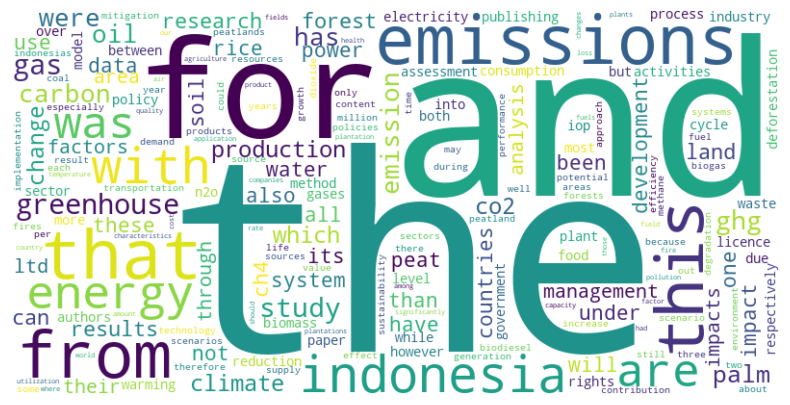

In [358]:
# Visualisasi WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sorted_result)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [359]:
# Ingin mengetahui kata dengan frekuensi terbesar
top20 = dict(abstract_count.most_common(20))
top20_dict = dict(sorted(top20.items(), key=lambda item: (item[1], item[0])))
print(top20_dict)

{'oil': 283, 'has': 291, 'emission': 300, 'carbon': 302, 'ghg': 314, 'study': 339, 'gas': 371, 'greenhouse': 382, 'was': 395, 'are': 407, 'energy': 417, 'with': 451, 'indonesia': 460, 'from': 608, 'this': 629, 'that': 677, 'emissions': 678, 'for': 750, 'and': 2808, 'the': 5030}


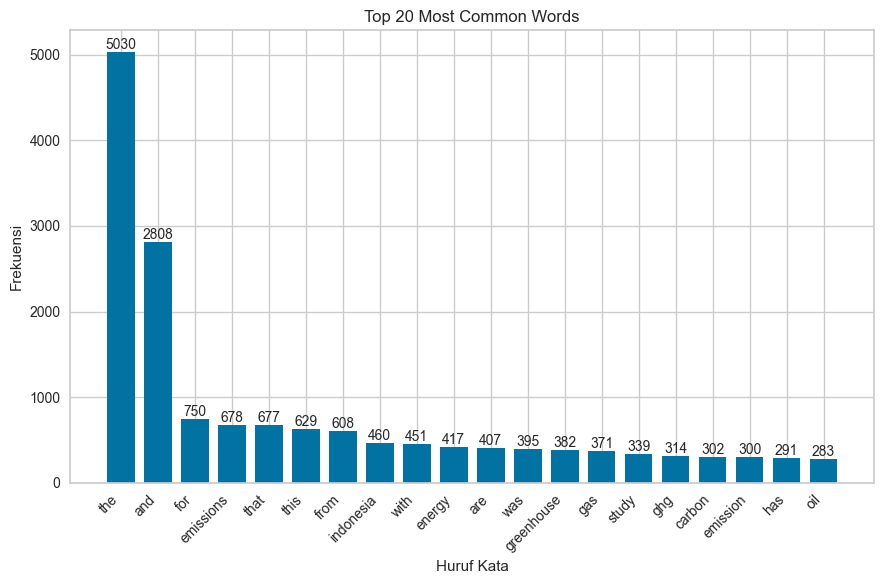

In [360]:
import matplotlib.pyplot as plt

data = {k: v for k, v in sorted(top20_dict.items(), key=lambda item: item[1], reverse=True)}

labels = list(data.keys())
values = list(data.values())
plt.figure(figsize=(9, 6))
plt.bar(labels, values, width=0.75, align='center')

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

plt.ylabel('Frekuensi')
plt.xlabel('Huruf Kata')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Common Words')

plt.tight_layout()
plt.show()


In [361]:
# Save DataFrame to a CSV file untuk diproses lebih lanjut analisisnya
df = pd.DataFrame(list(sorted_result.items()), columns=['Word', 'Counts'])
csv_file_path = 'data_luhn.csv'
df.to_csv(csv_file_path, index=False)